In [1]:
import os
import sys
# Setting the path for XLuminA modules:
current_path = os.path.abspath(os.path.join('..'))
module_path = os.path.join(current_path)

if module_path not in sys.path:
    sys.path.append(module_path)

from xlumina.__init__ import um, nm, cm, mm, radians
import xlumina.wave_optics as wo
import xlumina.vectorized_optics as vo
from xlumina.optical_elements import *
from xlumina.toolbox import space, image_to_binary_mask, draw_sSLM, wrap_phase
import jax.numpy as jnp
import jax

In [2]:
# System parameters
sensor_size = 512  # Resolution
wavelength = 632.8 * nm  # HeNe laser wavelength
x_total = 2000 * um  # Total simulation window
x, y = space(x_total, sensor_size)
jones_vector = jnp.array([1, 1])

print(f"Wavelength: {wavelength/nm:.1f} nm")
print(f"Simulation window: {x_total/um:.0f} μm")
print(f"Resolution: {sensor_size} x {sensor_size} pixels")


Wavelength: 632.8 nm
Simulation window: 2000 μm
Resolution: 512 x 512 pixels


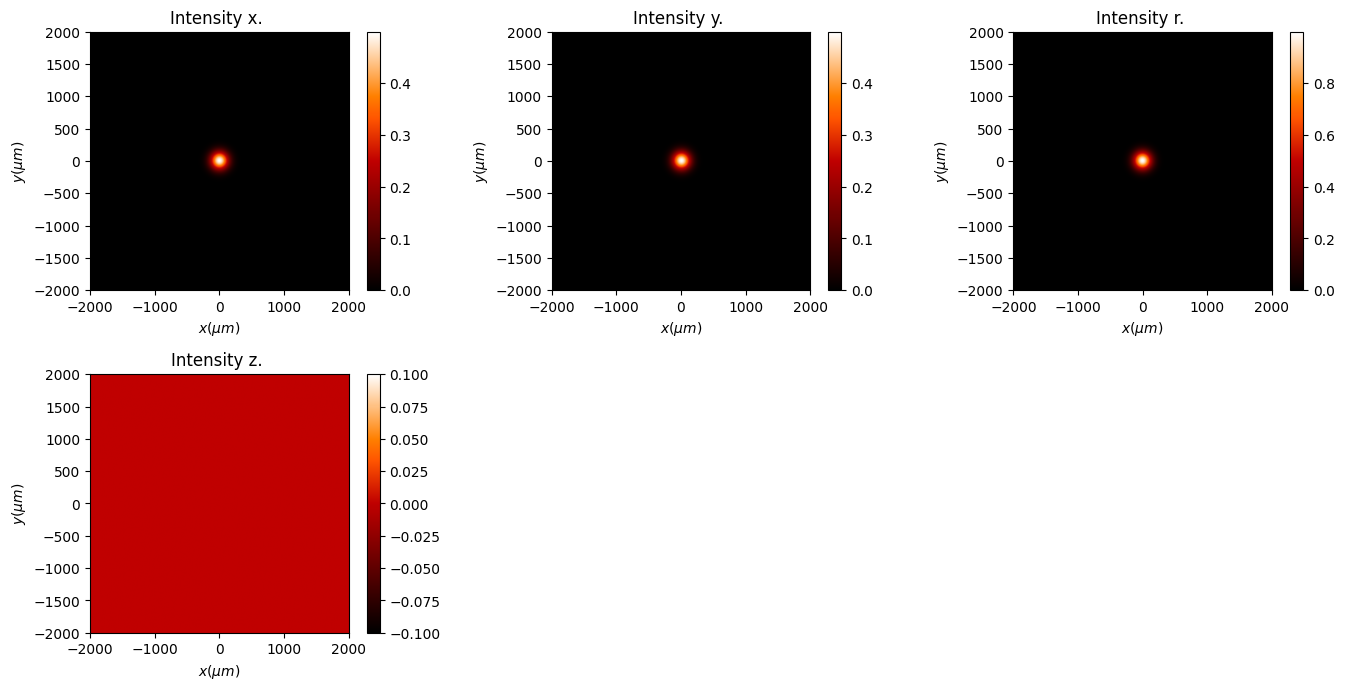

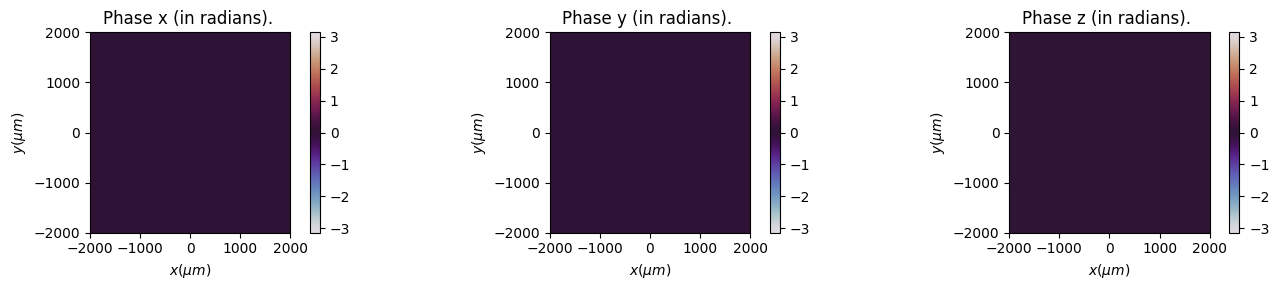

In [7]:
input_light = vo.PolarizedLightSource(x, y, wavelength)
w0 = (200*um, 200*um)  # Beam waist
input_light.gaussian_beam(w0=w0, jones_vector=jones_vector)
input_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')
input_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Phase')

In [44]:
def MZI(input_light, phase_difference):
    """
    Mach-Zehnder Interferometer with 50:50 beam splitters
    
    Parameters:
        input_light: Input light field
        phase_difference: Phase difference between arms (in radians)
    """


    arm1, arm2 = BS_symmetric_SI(input_light, jnp.pi/4)

    arm1_shifted = phase_shifter(arm1, 0.0)  # Reference arm
    arm2_shifted = phase_shifter(arm2, phase_difference)  # Phase-shifted arm
    
    output_1, output_2 = BS_symmetric(arm1_shifted, arm2_shifted, jnp.pi/4)

    intermediate_fields = {
        'arm1': arm1,
        'arm2': arm2,
        'arm1_shifted': arm1_shifted,
        'arm2_shifted': arm2_shifted
    }
    
    return output_1, output_2, intermediate_fields

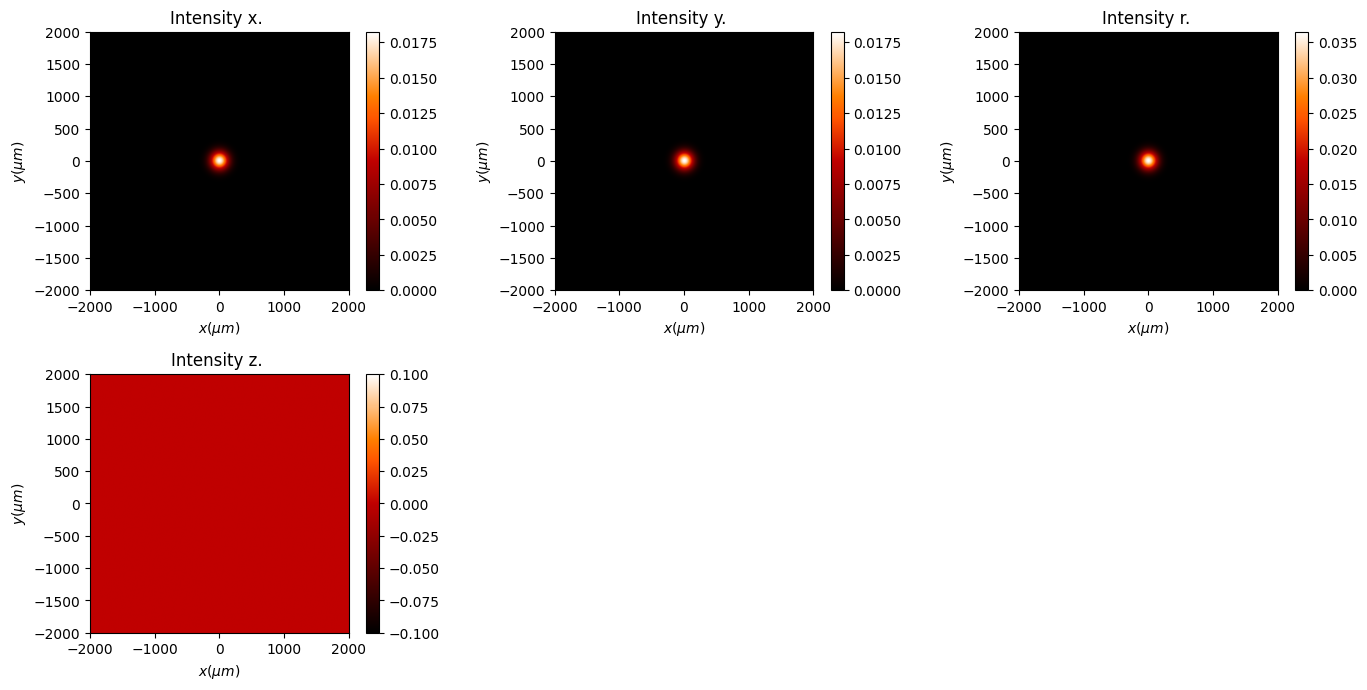

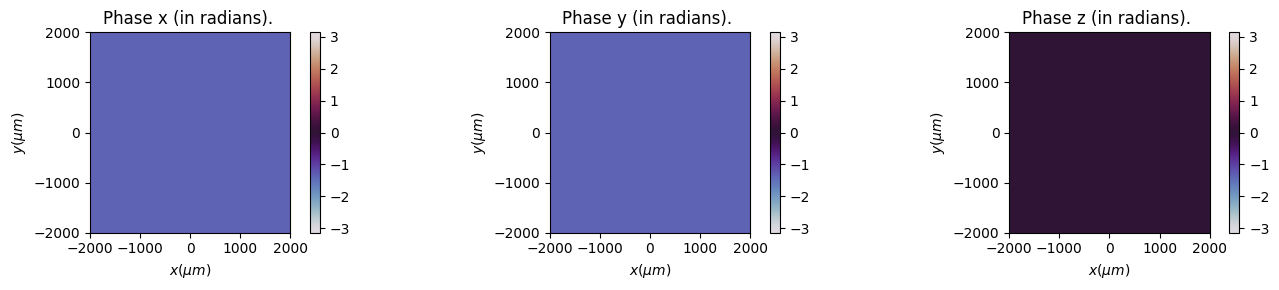

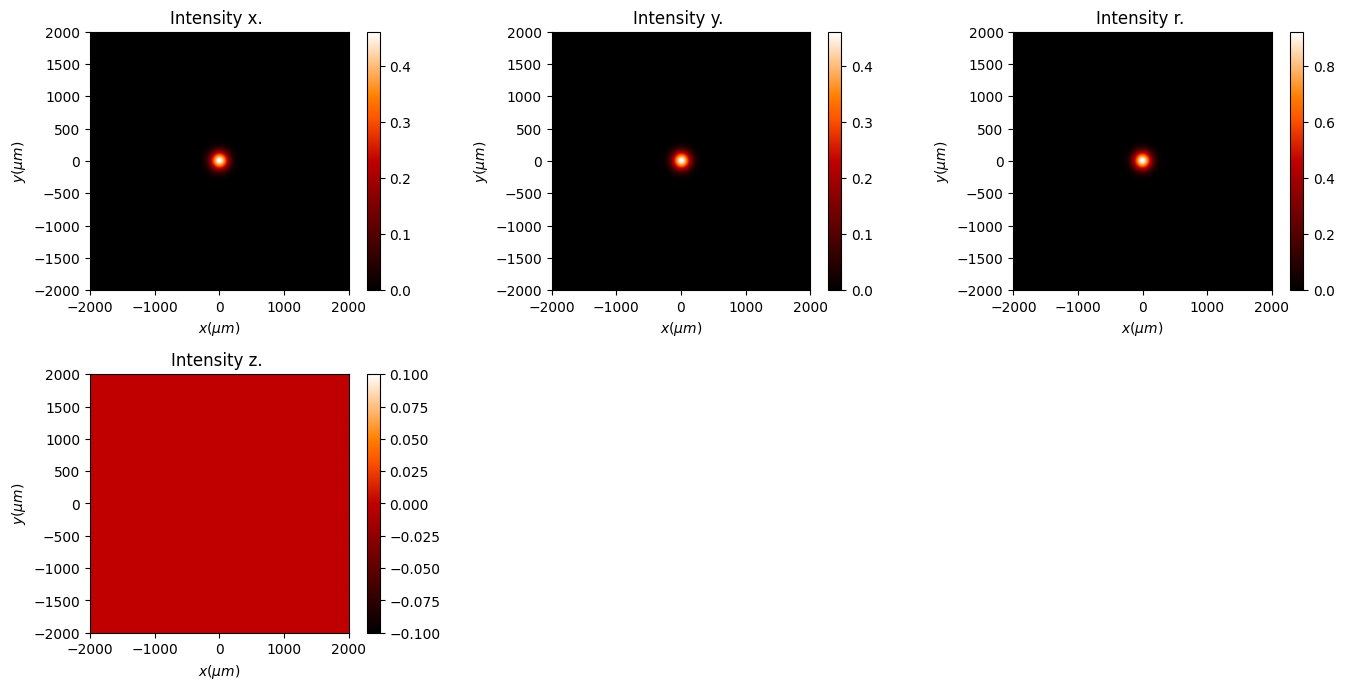

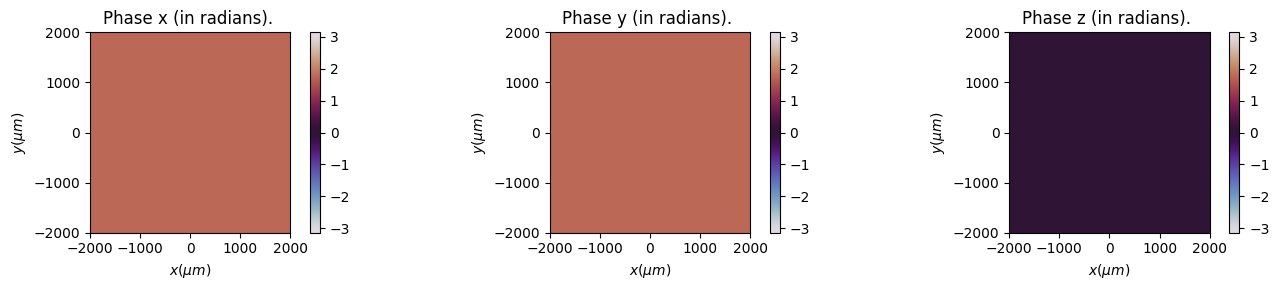

In [45]:
mzi_light, mzi_light_2, _ = MZI(input_light, jnp.pi/8)

mzi_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')
mzi_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Phase')

mzi_light_2.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')
mzi_light_2.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Phase')

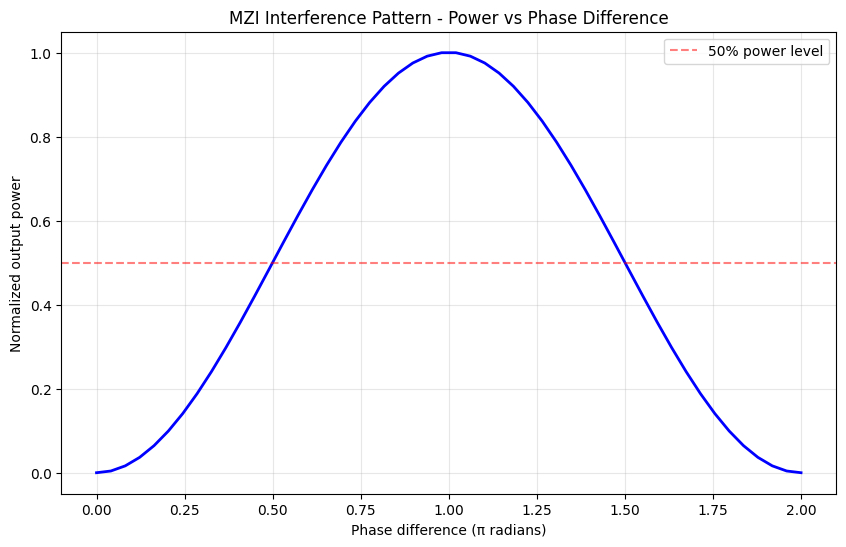

Interference visibility: 1.000
(Perfect MZI should have visibility = 1.0)

=== Spatial Interference Pattern (π/2 phase shift) ===


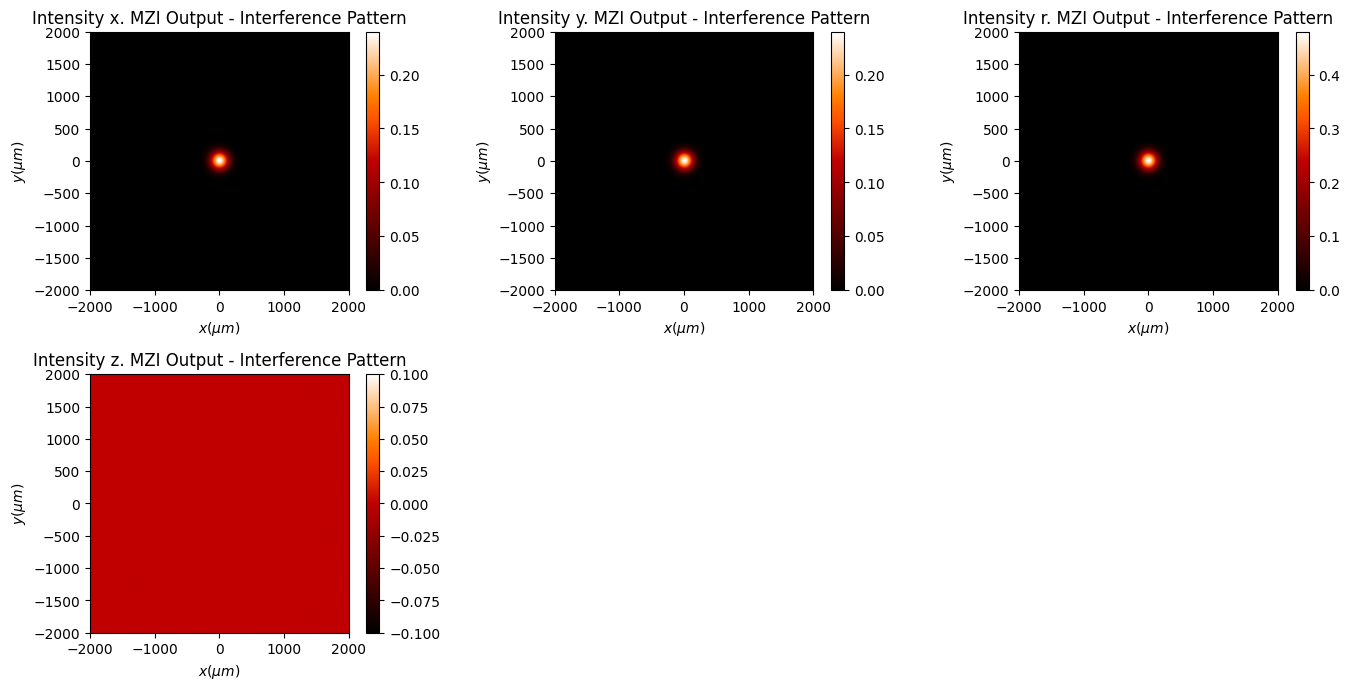

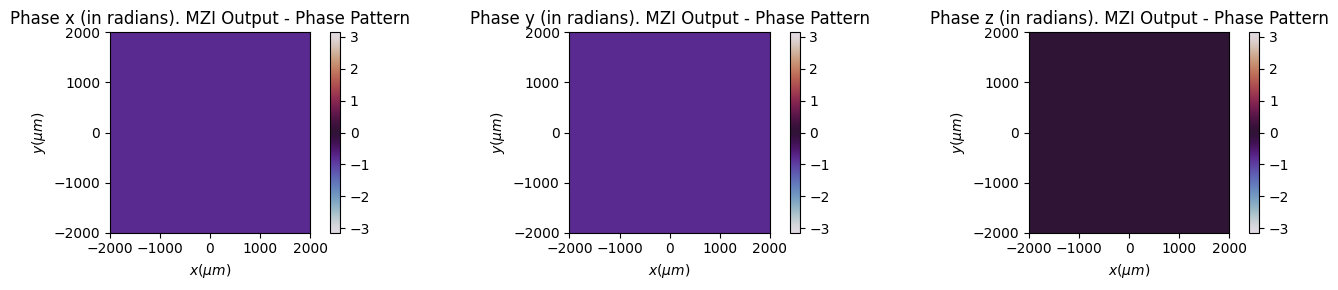

In [46]:
# Create a comprehensive analysis of the MZI
import matplotlib.pyplot as plt

# Test different phase shifts and show interference visibility
phase_values = jnp.linspace(0, 2*jnp.pi, 50)
output_powers = []

for phase in phase_values:
    mzi_out1, mzi_out2, _ = MZI(input_light, phase)
    # Calculate total power in output 1
    power1 = jnp.sum(jnp.abs(mzi_out1.Ex)**2 + jnp.abs(mzi_out1.Ey)**2)
    output_powers.append(power1)

output_powers = jnp.array(output_powers)

# Plot interference curve
plt.figure(figsize=(10, 6))
plt.plot(phase_values/jnp.pi, output_powers/jnp.max(output_powers), 'b-', linewidth=2)
plt.xlabel('Phase difference (π radians)')
plt.ylabel('Normalized output power')
plt.title('MZI Interference Pattern - Power vs Phase Difference')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% power level')
plt.legend()
plt.show()

# Show visibility calculation
visibility = (jnp.max(output_powers) - jnp.min(output_powers)) / (jnp.max(output_powers) + jnp.min(output_powers))
print(f"Interference visibility: {visibility:.3f}")
print(f"(Perfect MZI should have visibility = 1.0)")

# Show spatial interference pattern for π/2 phase shift
print("\n=== Spatial Interference Pattern (π/2 phase shift) ===")
mzi_spatial, _, _ = MZI(input_light, jnp.pi/2)
mzi_spatial.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity', extra_title='MZI Output - Interference Pattern')
mzi_spatial.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Phase', extra_title='MZI Output - Phase Pattern')